In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [2]:
occ_by_ind = pd.read_excel("../data/OES/natsector_M2021_dl.xlsx")

In [3]:
# A lot of total employment and wage estimates for "major" are showing up as unavailable. At some point we need 
# to estimate them from more granular occupation data
occ_by_ind = occ_by_ind[occ_by_ind['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP"]]
occ_by_ind.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_by_ind['TOT_EMP'], errors='coerce').fillna(0)
occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
pivot_df = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['NAICS_TITLE'], values='EMP_PCT').fillna(0)

In [4]:
index_dict = {'Food S':'Accommodation and Food Services', 'Rec':'Arts, Entertainment, and Recreation', 
                'Const':'Construction', 'Educ S':'Educational Services', 'Fin':'Finance and Insurance', 
                'Gov':'Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)', 
                'Health':'Health Care and Social Assistance',
                'Info': 'Information', 'Mining':'Mining, Quarrying, and Oil and Gas Extraction', 
                'Manu': 'Manufacturing', 'Other S':'Other Services (except Public Administration)', 
                'Bus S': 'Professional, Scientific, and Technical Services', 
                'Real Est':'Real Estate and Rental and Leasing', 'Retail':'Retail Trade', 'Trans':'Transportation and Warehousing',
                'Whsale':'Wholesale Trade', 'Management':'Management of Companies and Enterprises',
                'Admin': 'Administrative and Support and Waste Management and Remediation Services', 
                'Agri': 'Agriculture, Forestry, Fishing and Hunting'}
occ_map = {'Architecture and Engineering Occupations': 'Archi + Eng', 
           'Arts, Design, Entertainment, Sports, and Media Occupations': 'Arts',
           'Building and Grounds Cleaning and Maintenance Occupations': 'Building Maintenance',
           'Business and Financial Operations Occupations': 'Business Ops',
           'Community and Social Service Occupations': 'Social Service',
           'Computer and Mathematical Occupations': 'Comp + Math',
           'Construction and Extraction Occupations': 'Construction',
           'Educational Instruction and Library Occupations': 'Education',
           'Farming, Fishing, and Forestry Occupations': 'Farm + Fish + Forestry',
           'Food Preparation and Serving Related Occupations': 'Food Service',
           'Healthcare Practitioners and Technical Occupations': 'Healthcare Practitioners',
           'Healthcare Support Occupations': 'Healthcare Support', 
           'Installation, Maintenance, and Repair Occupations': 'Install, Maintain, Repair', 
           'Legal Occupations': 'Legal', 'Life, Physical, and Social Science Occupations':'Science',
           'Management Occupations': 'Management', 'Office and Administrative Support Occupations': 'Admin Support',
           'Personal Care and Service Occupations': 'Personal Care', 'Production Occupations': 'Production',
           'Protective Service Occupations': 'Protective Service', 'Sales and Related Occupations': 'Sales', 
           'Transportation and Material Moving Occupations': 'Transportation'}
index_dict_swap = {v: k for k, v in index_dict.items()}
pivot_df = pivot_df.rename(index=index_dict_swap, columns=occ_map)

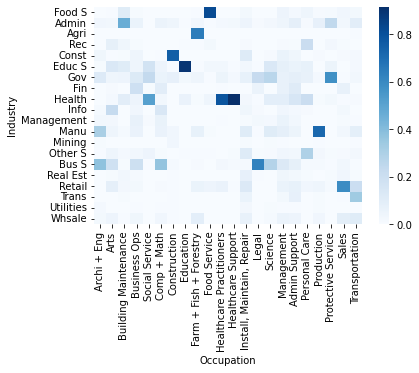

In [30]:
sns.heatmap(pivot_df, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.savefig('../output/occupation_heatmap.png',dpi=300)

In [26]:
data_dir = '../data/clean/'
dfA      = pd.read_csv(data_dir + 'A.csv')
dfA.columns
dfA.index = dfA.BEA_sector
dfA = dfA.drop(labels=['BEA_sector'],axis=1)


In [27]:
sectors_dict = {'Food S':'Accommodation and food services','Rec':'Arts, entertainment, and recreation',
                'Const':'Construction','Dur':'Durable goods','Educ S':'Educational services','Fin':'Finance and insurance',
                'Gov':'Government','Health S':'Health care and social assistance','Info':'Information','Mining':'Mining',
                'Nondur':'Nondurable goods','Other S':'Other services, except government', 'Bus S':'Professional and business services',
                'Real Est':'Real estate and rental and leasing','Retail':'Retail trade','Trans':'Transportation and warehousing',
                'Whsale':'Wholesale trade'}
sector_dict_swap = {v: k for k, v in sectors_dict.items()}
dfA = dfA.rename(index=sector_dict_swap, columns=sector_dict_swap)
dfA

,Food S,Rec,Const,Dur,Educ S,Fin,Gov,Health S,Info,Mining,Nondur,Other S,Bus S,Real Est,Retail,Trans,Whsale
BEA_sector,,,,,,,,,,,,,,,,,
Food S,0.012318,0.003711,0.003056,0.021572,0.000000e+00,0.024068,0.011999,0.000000,0.014783,0.001402,0.132580,0.016872,0.206401,0.086903,0.000000,0.006531,0.000015
Rec,0.010942,0.072374,0.001957,0.024528,7.641657e-03,0.028694,0.002958,0.000394,0.012196,0.005550,0.060205,0.014867,0.162493,0.143628,0.000000,0.017949,0.000602
Const,0.000503,0.000246,0.000179,0.346021,9.474246e-07,0.010333,0.000009,0.000000,0.007220,0.017354,0.107710,0.005813,0.061848,0.025349,0.000000,0.000533,0.000015
Dur,0.003020,0.000448,0.002026,0.502561,0.000000e+00,0.014729,0.001386,0.000000,0.006541,0.016680,0.077382,0.004482,0.070104,0.015094,0.000000,0.004444,0.005914
Educ S,0.008165,0.003063,0.001319,0.029208,1.298247e-02,0.019119,0.003628,0.000000,0.025605,0.001739,0.053354,0.012378,0.067301,0.150283,0.000000,0.007800,0.000050
Fin,0.013399,0.001994,0.005160,0.002248,1.782347e-05,0.353780,0.005593,0.000000,0.020973,0.000000,0.014851,0.014906,0.120813,0.042207,0.000000,0.010870,0.000163
Gov,0.005584,0.001773,0.023171,0.038346,3.263269e-03,0.026676,0.002692,0.002513,0.026455,0.011600,0.114110,0.008865,0.090615,0.026334,0.000000,0.014358,0.000011
Health S,0.019343,0.001101,0.000758,0.042501,5.956761e-05,0.046670,0.004034,0.012649,0.010379,0.000180,0.099858,0.011311,0.102850,0.077776,0.000000,0.007114,0.000376
Info,0.007448,0.029362,0.002731,0.068697,4.791031e-04,0.015129,0.004909,0.000000,0.226946,0.000496,0.046530,0.007878,0.173097,0.053388,0.000000,0.015580,0.004473


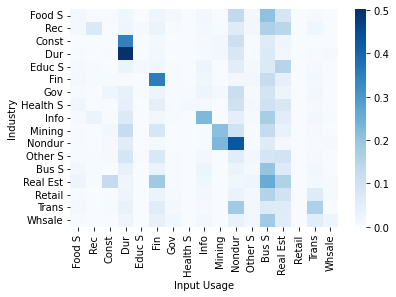

In [29]:
sns.heatmap(dfA, cmap="Blues")
plt.xlabel('Input Usage')
plt.ylabel('Industry')
plt.savefig('../output/sectors_heatmap.png',dpi=300)